# `Health Insurance Cross Sell Prediction`

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

In [81]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import warnings


warnings.filterwarnings("ignore")
pd.options.display.max_columns=None

In [2]:
train_df = pd.read_csv("../data/raw/train.csv")

In [3]:
train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [5]:
train_df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
train_df.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [7]:
train_df.duplicated().sum()

0

* Inference
     * The Data don't have any null and duplicated values

## `EDA`

In [8]:
def value_count_norm(df, feature):
    value_count = df[feature].value_counts()
    value_count_norm_1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm_1_concat = pd.concat([value_count, value_count_norm_1], axis=1)
    value_count_norm_1_concat.columns = ['Count', 'Frequency %']
    return value_count_norm_1_concat

In [9]:
def create_pie_chart(df, feature):
    n = len(value_count_norm(df, feature).index)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(value_count_norm(df, feature).iloc[:, 1],
            colors = colors, autopct='%1.2f%%', 
            labels=value_count_norm(df, feature).index)
    plt.title('{}'.format(feature))
    return plt.show()

In [10]:
def create_hist_plot(df, feature):
    figure(figsize=(20, 8))
    sns.histplot(df[feature], kde=True)
    plt.title('{}'.format(feature))
    return plt.show()

In [11]:
train_df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [12]:
def get_info(df, feature):
    match feature:
        case 'Gender'|'Driving_License'|'Region_Code'|'Previously_Insured'|'Vehicle_Damage'|'Vehicle_Age':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Value count:\n{}'.format(value_count_norm(df, feature)))
        case 'Age'|'Region_Code'|'Annual_Premium'|'Policy_Sales_Channel'|'Vintage'|'Region_Code':
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Error')

In [13]:
def get_report(df, feature):
    match feature:
        case 'Gender'|'Driving_License'|'Previously_Insured'|'Vehicle_Damage'|'Vehicle_Age':
            get_info(df, feature)
            print('*'*50)
            create_pie_chart(df, feature)
        case 'Age'|'Region_Code'|'Annual_Premium'|'Policy_Sales_Channel'|'Vintage':
            get_info(df, feature)
            print('*'*50)
            create_hist_plot(df, feature)
        case _:
            print("Error")

Description:
count     381109
unique         2
top         Male
freq      206089
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
         Count  Frequency %
Male    206089     54.07613
Female  175020     45.92387
**************************************************


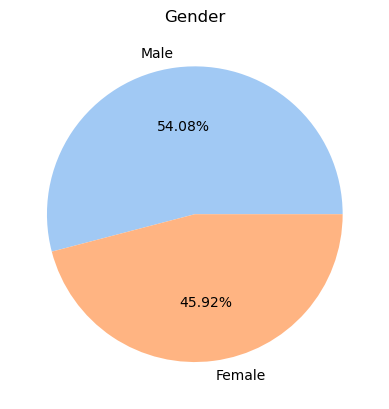

In [14]:
get_report(train_df, 'Gender')

Description:
count       381109
unique           3
top       1-2 Year
freq        200316
Name: Vehicle_Age, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency %
1-2 Year   200316    52.561341
< 1 Year   164786    43.238549
> 2 Years   16007     4.200111
**************************************************


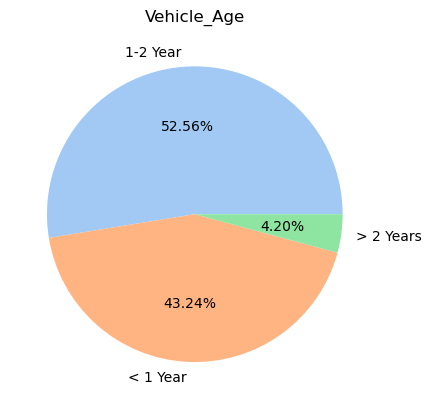

In [15]:
get_report(train_df, 'Vehicle_Age')

Description:
count    381109.000000
mean          0.997869
std           0.046110
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Driving_License, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency %
1  380297    99.786938
0     812     0.213062
**************************************************


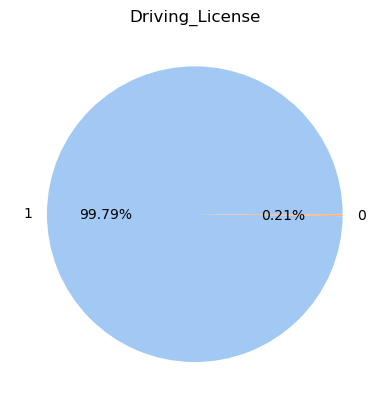

In [16]:
get_report(train_df, 'Driving_License')

Description:
count    381109.000000
mean          0.458210
std           0.498251
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Previously_Insured, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency %
0  206481    54.178988
1  174628    45.821012
**************************************************


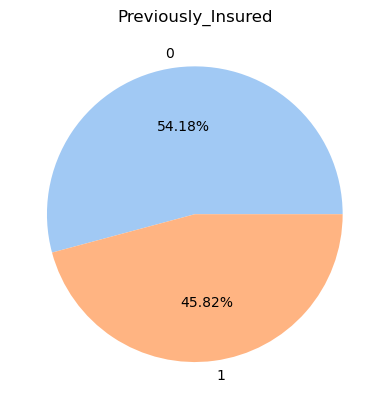

In [17]:
get_report(train_df, 'Previously_Insured')

Description:
count     381109
unique         2
top          Yes
freq      192413
Name: Vehicle_Damage, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency %
Yes  192413    50.487656
No   188696    49.512344
**************************************************


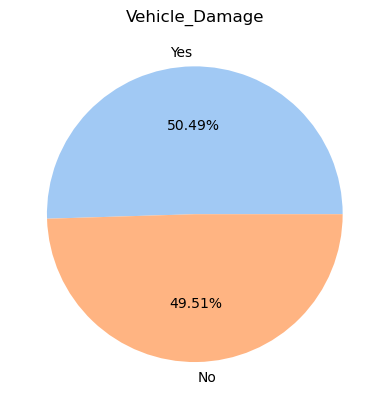

In [18]:
get_report(train_df, 'Vehicle_Damage')

Description:
count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64
**************************************************
Object type:int64
**************************************************


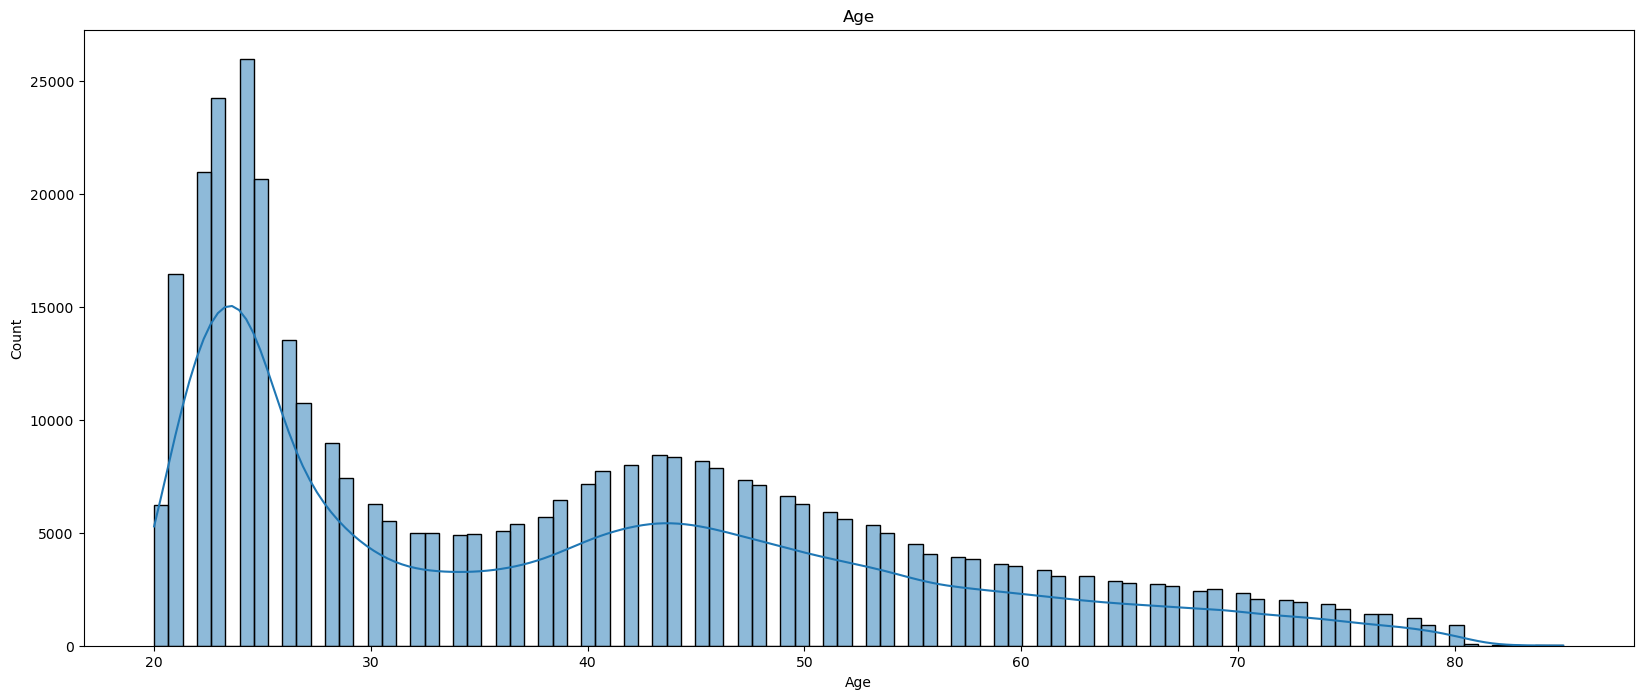

In [19]:
get_report(train_df, 'Age')

Description:
count    381109.000000
mean         26.388807
std          13.229888
min           0.000000
25%          15.000000
50%          28.000000
75%          35.000000
max          52.000000
Name: Region_Code, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
       Count  Frequency %
28.0  106415    27.922458
8.0    33877     8.889058
46.0   19749     5.181982
41.0   18263     4.792067
15.0   13308     3.491914
30.0   12191     3.198822
29.0   11065     2.903369
50.0   10243     2.687683
3.0     9251     2.427390
11.0    9232     2.422404
36.0    8797     2.308264
33.0    7654     2.008349
47.0    7436     1.951148
35.0    6942     1.821526
6.0     6280     1.647823
45.0    5605     1.470708
37.0    5501     1.443419
18.0    5153     1.352107
48.0    4681     1.228258
14.0    4678     1.227470
39.0    4644     1.218549
10.0    4374     1.147703
21.0    4266     1.119365
2.0     4

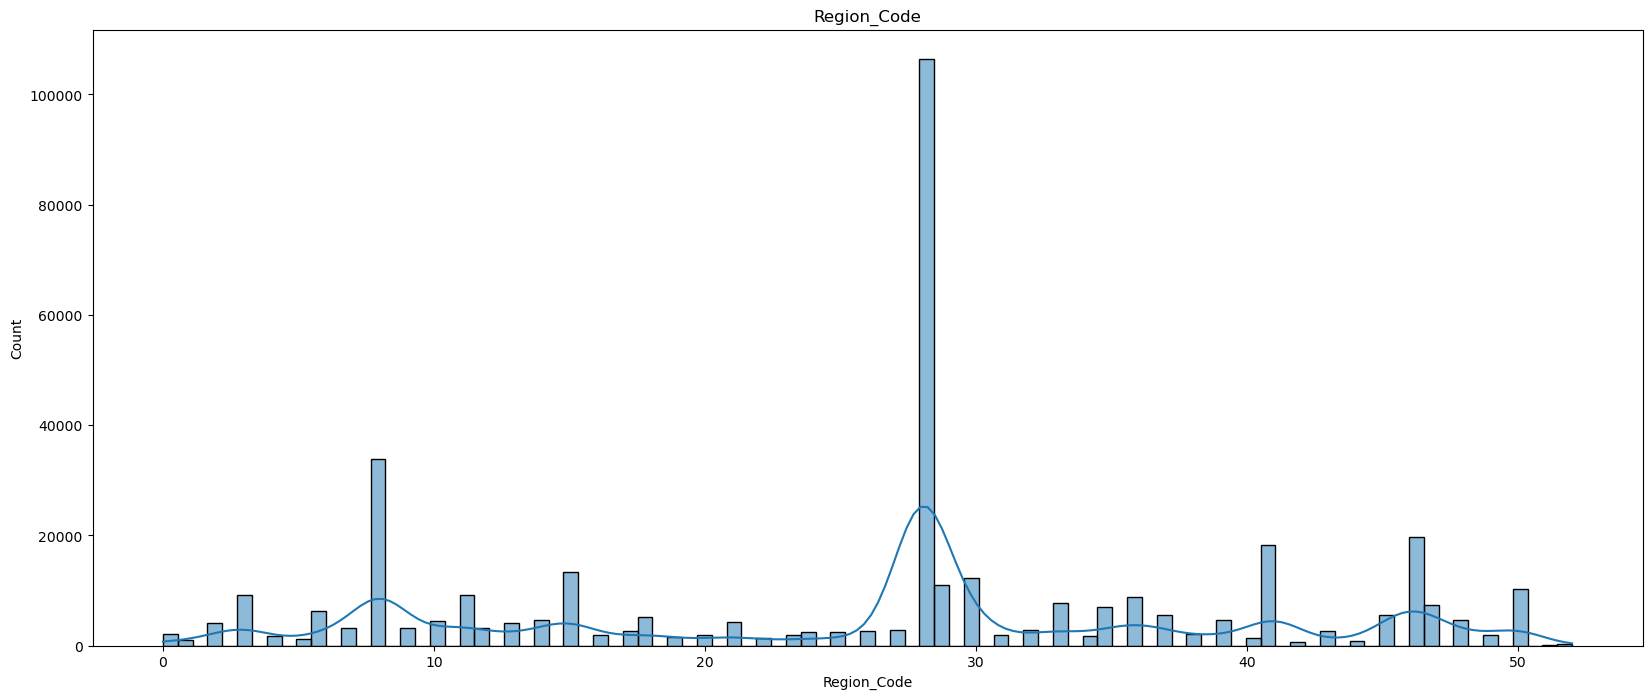

In [20]:
get_report(train_df, 'Region_Code')

Description:
count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64
**************************************************
Object type:int64
**************************************************


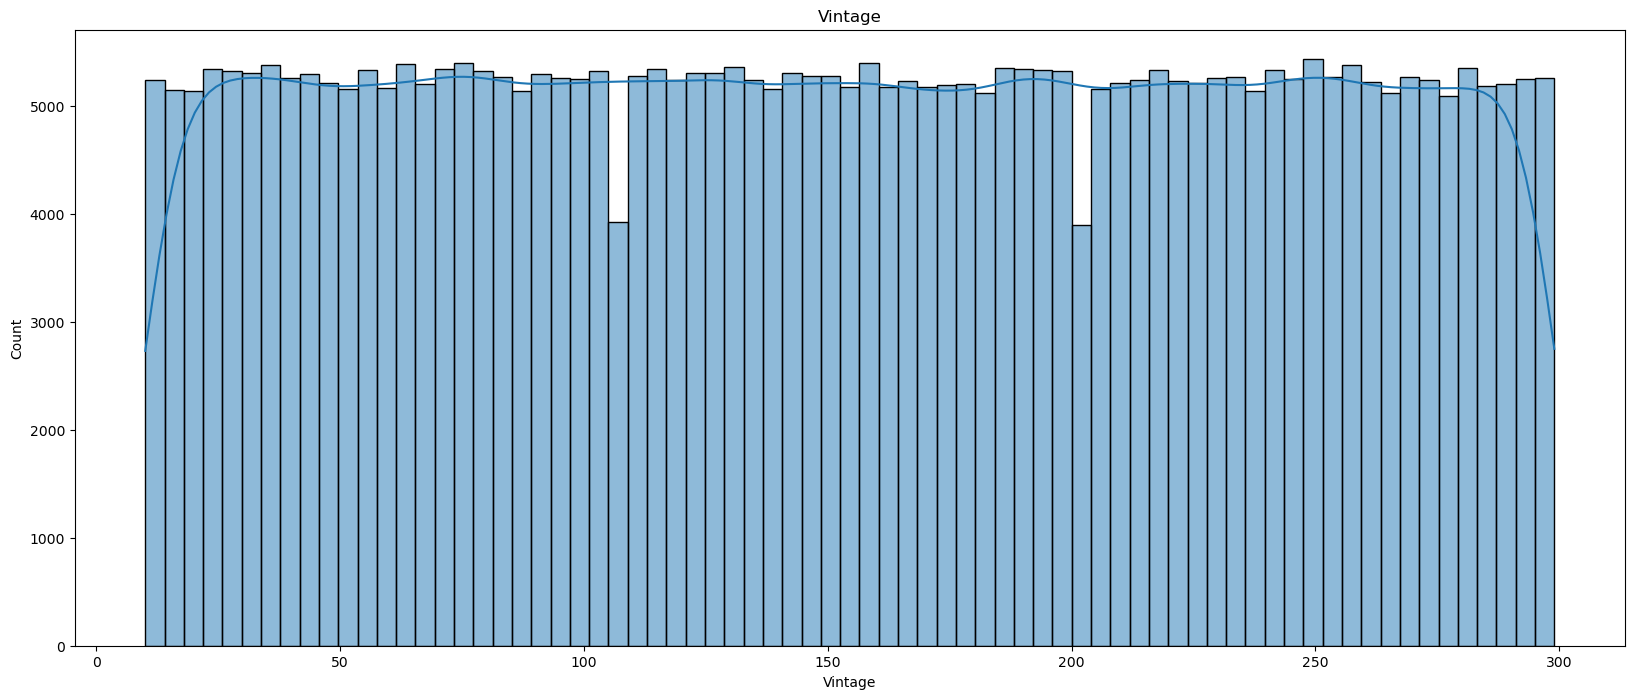

In [21]:
get_report(train_df, 'Vintage')

Description:
count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64
**************************************************
Object type:float64
**************************************************


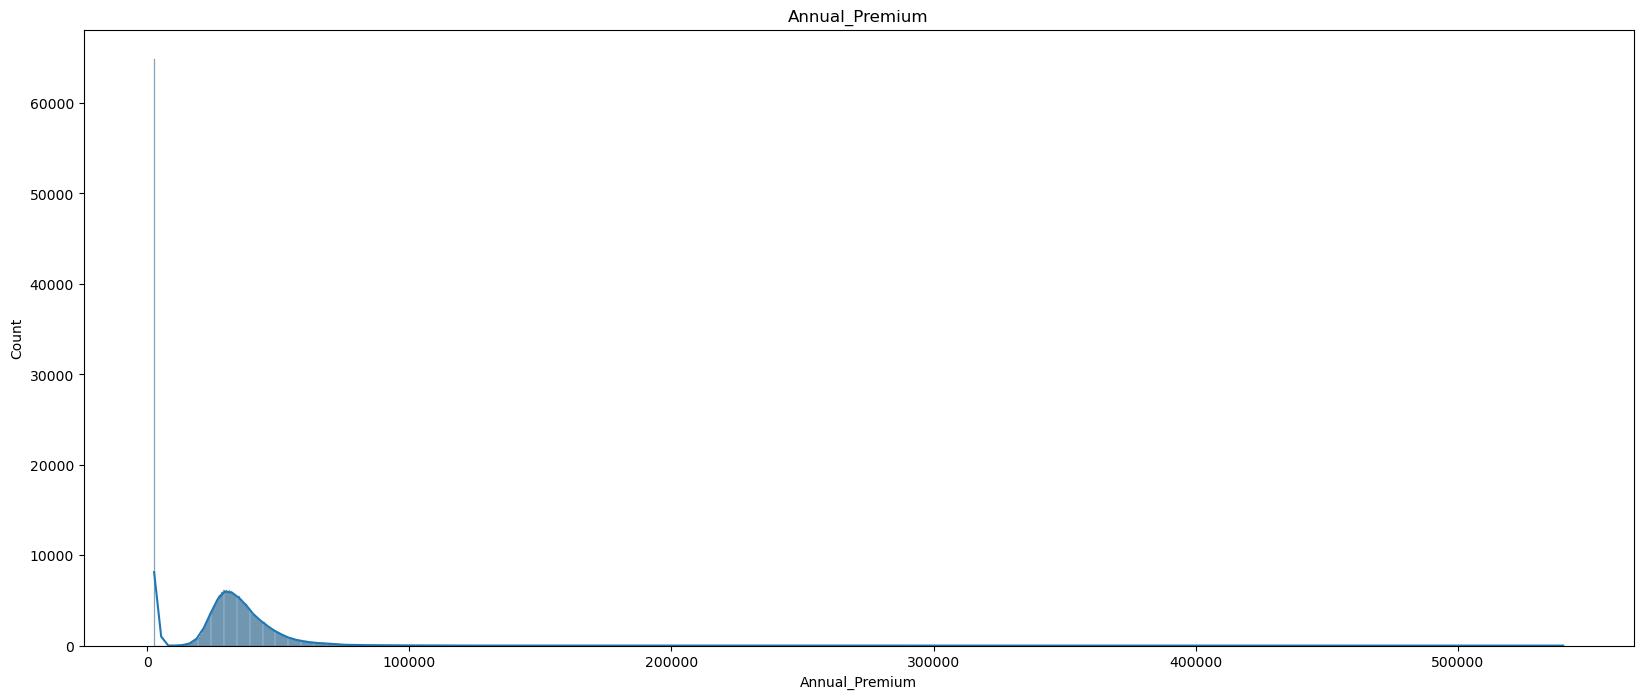

In [22]:
get_report(train_df, 'Annual_Premium')

Description:
count    381109.000000
mean        112.034295
std          54.203995
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64
**************************************************
Object type:float64
**************************************************


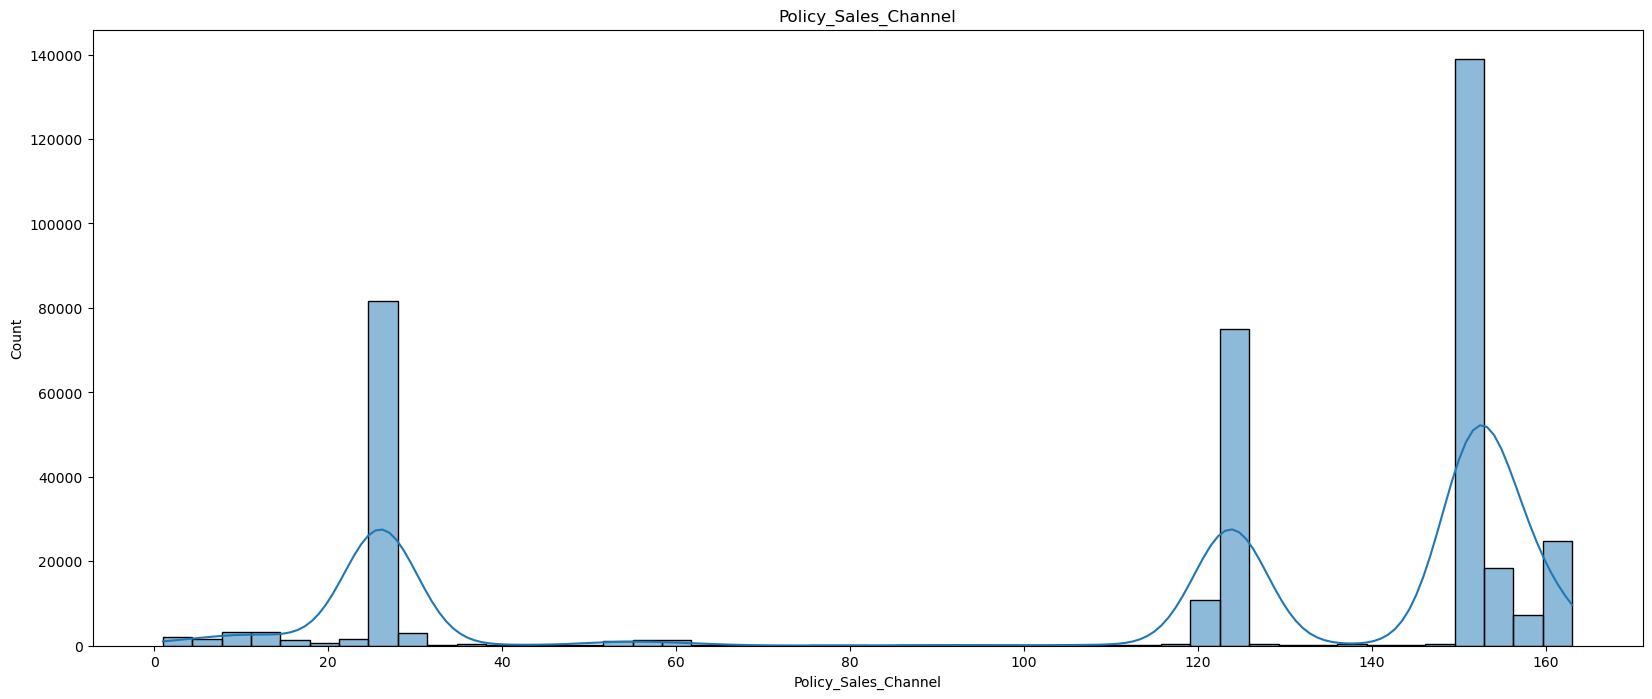

In [23]:
get_report(train_df, 'Policy_Sales_Channel')

### `EDA on Vehicle Damage`

In [24]:
damage_1 = train_df[train_df['Vehicle_Damage'] == 'Yes']
damage_0 = train_df[train_df['Vehicle_Damage'] == 'No']

Description:
count     192413
unique         2
top         Male
freq      112748
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
         Count  Frequency %
Male    112748    58.596872
Female   79665    41.403128
**************************************************


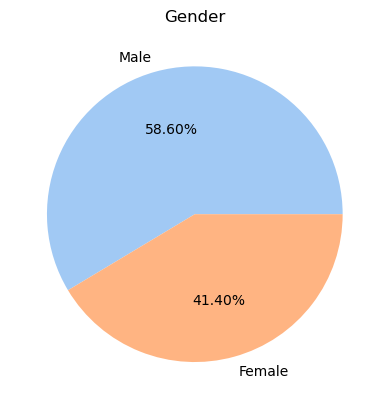

In [25]:
get_report(damage_1, 'Gender')

Description:
count     188696
unique         2
top       Female
freq       95355
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency %
Female  95355    50.533663
Male    93341    49.466337
**************************************************


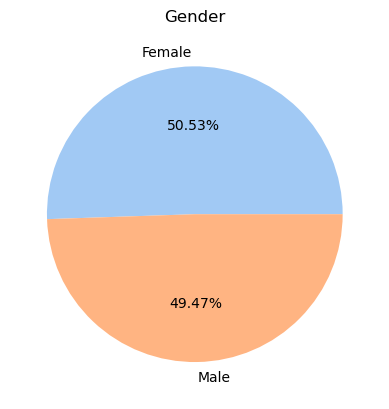

In [26]:
get_report(damage_0, 'Gender')

In [82]:
def get_report_2(df, feature, hue):
    match feature:
        case 'Age' | 'Region_Code' | 'Annual_Premium' | 'Policy_Sales_Channel' | 'Vintage':
            figure(figsize=(20, 8)) 
            sns.kdeplot(x=feature, hue=hue, palette = 'Set2', shade=True, data=df)
        case 'Vehicle_Damage' | 'Previously_Insured':
            figure(figsize=(20, 8))
            sns.countplot(x = feature, hue = hue , palette = 'Set2', data = df)
        case _:
            print("Error")

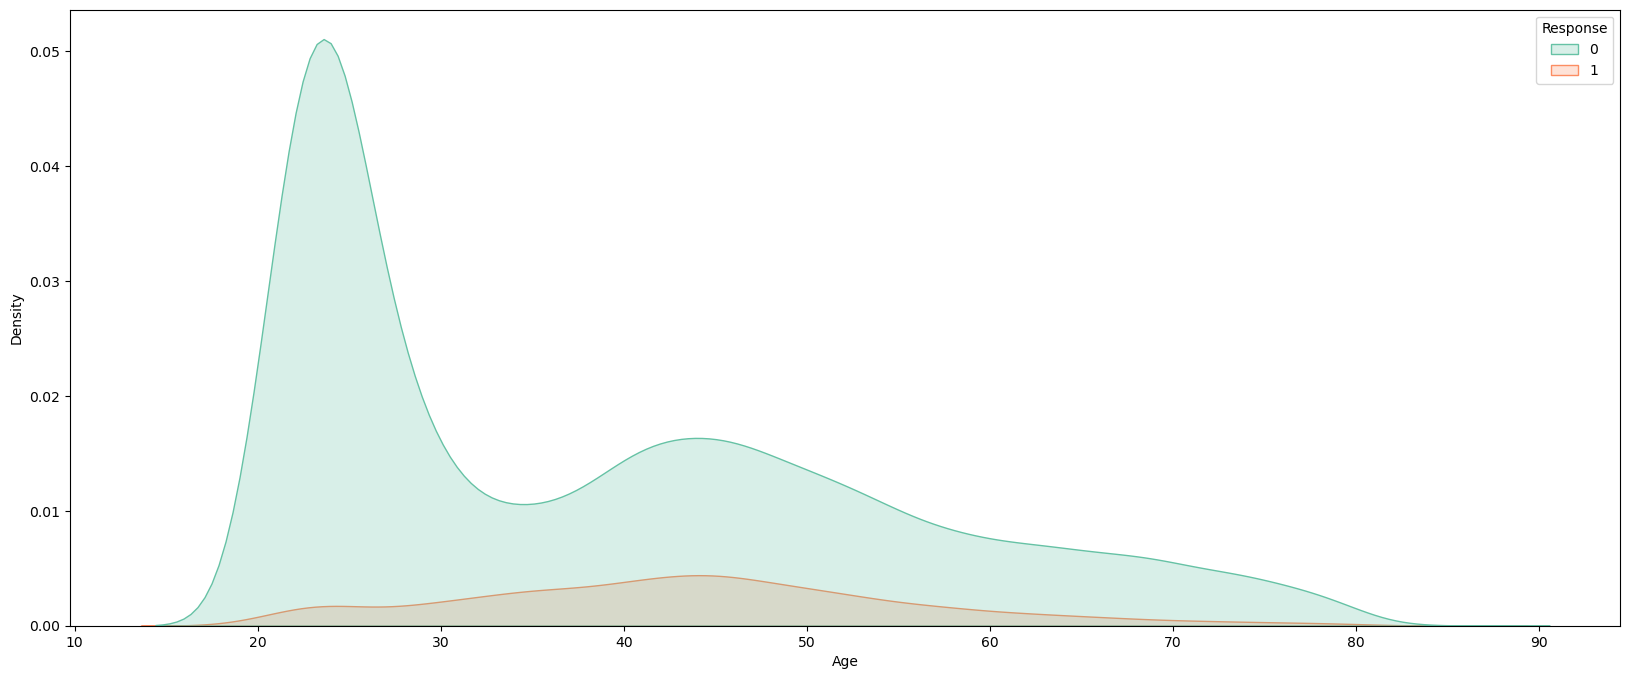

In [83]:
get_report_2(train_df, 'Age', 'Response')

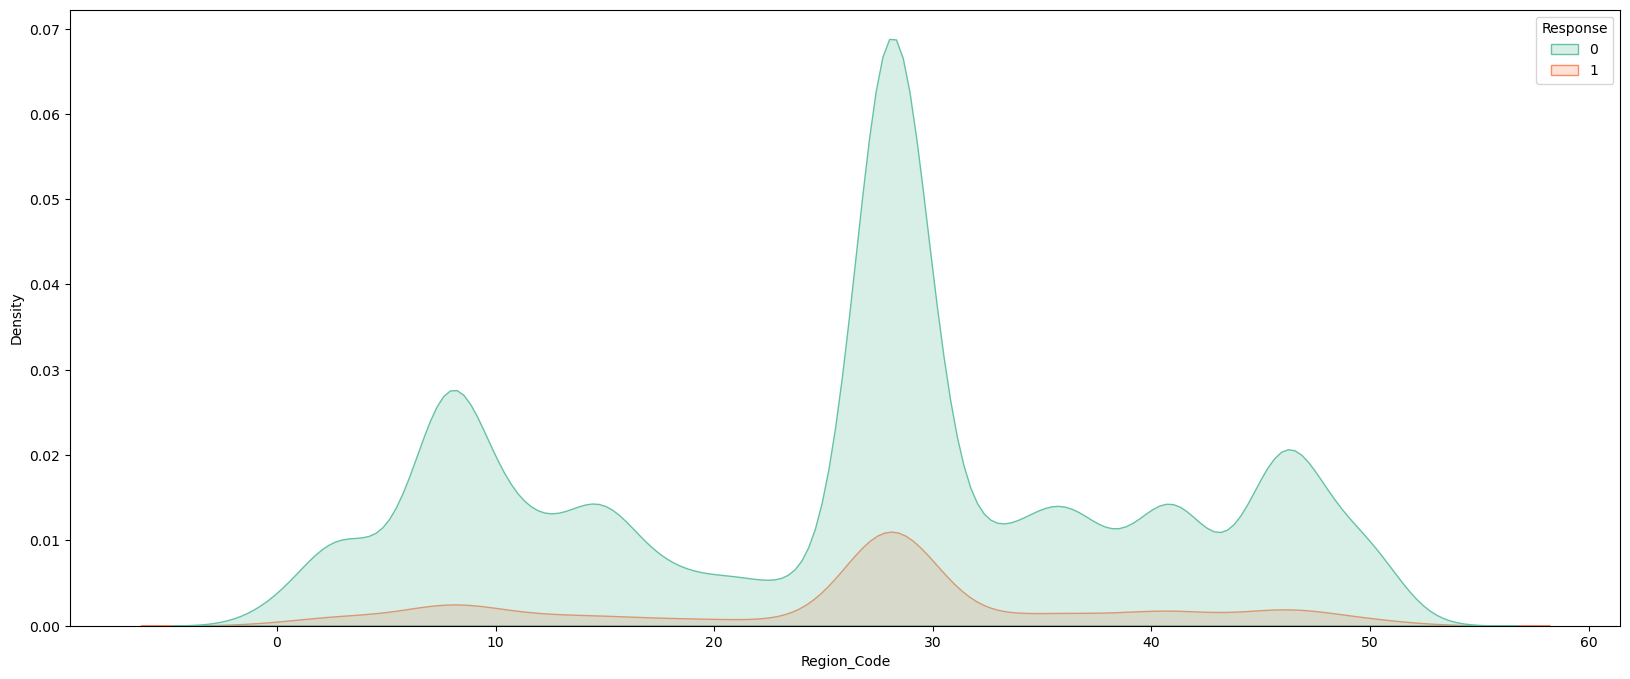

In [84]:
get_report_2(train_df, 'Region_Code', 'Response')

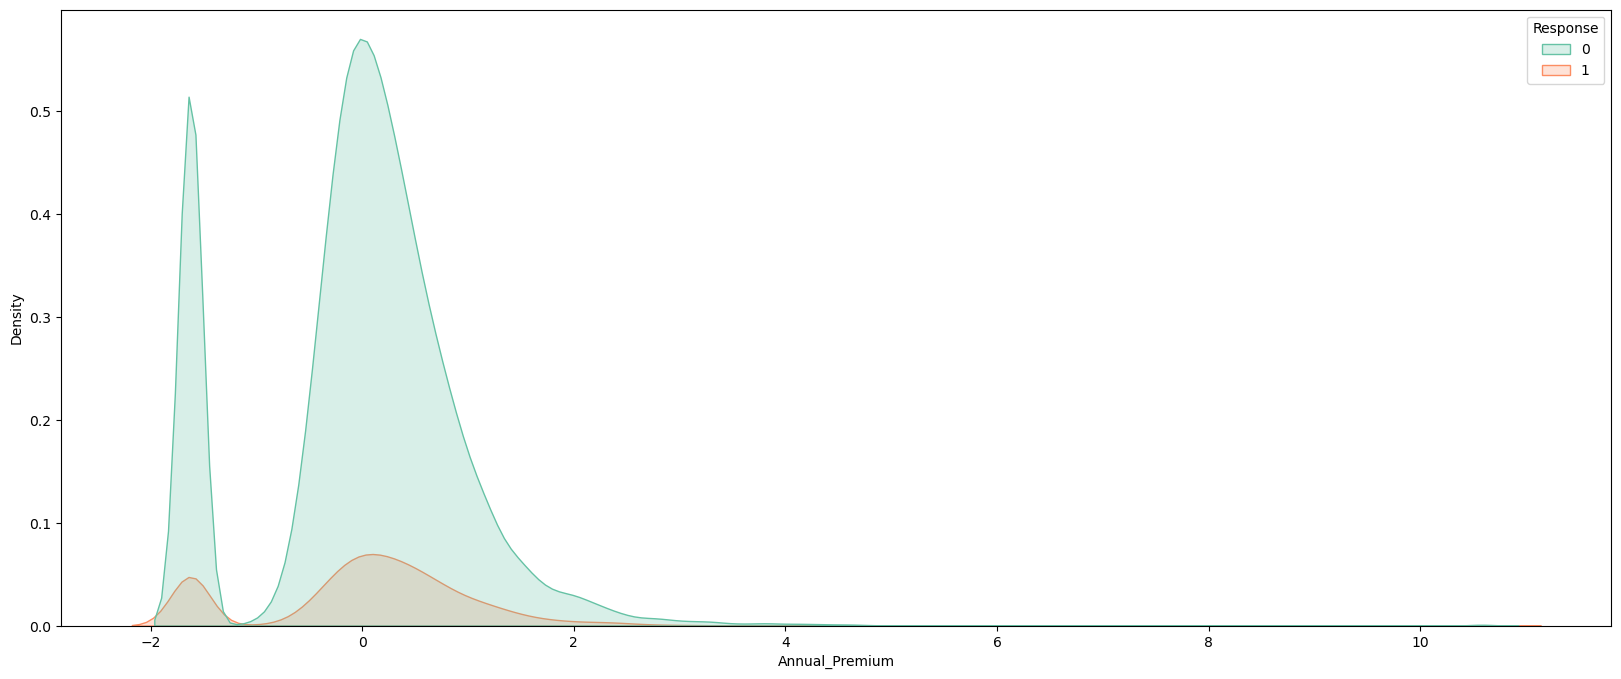

In [85]:
get_report_2(train_df, 'Annual_Premium', 'Response')

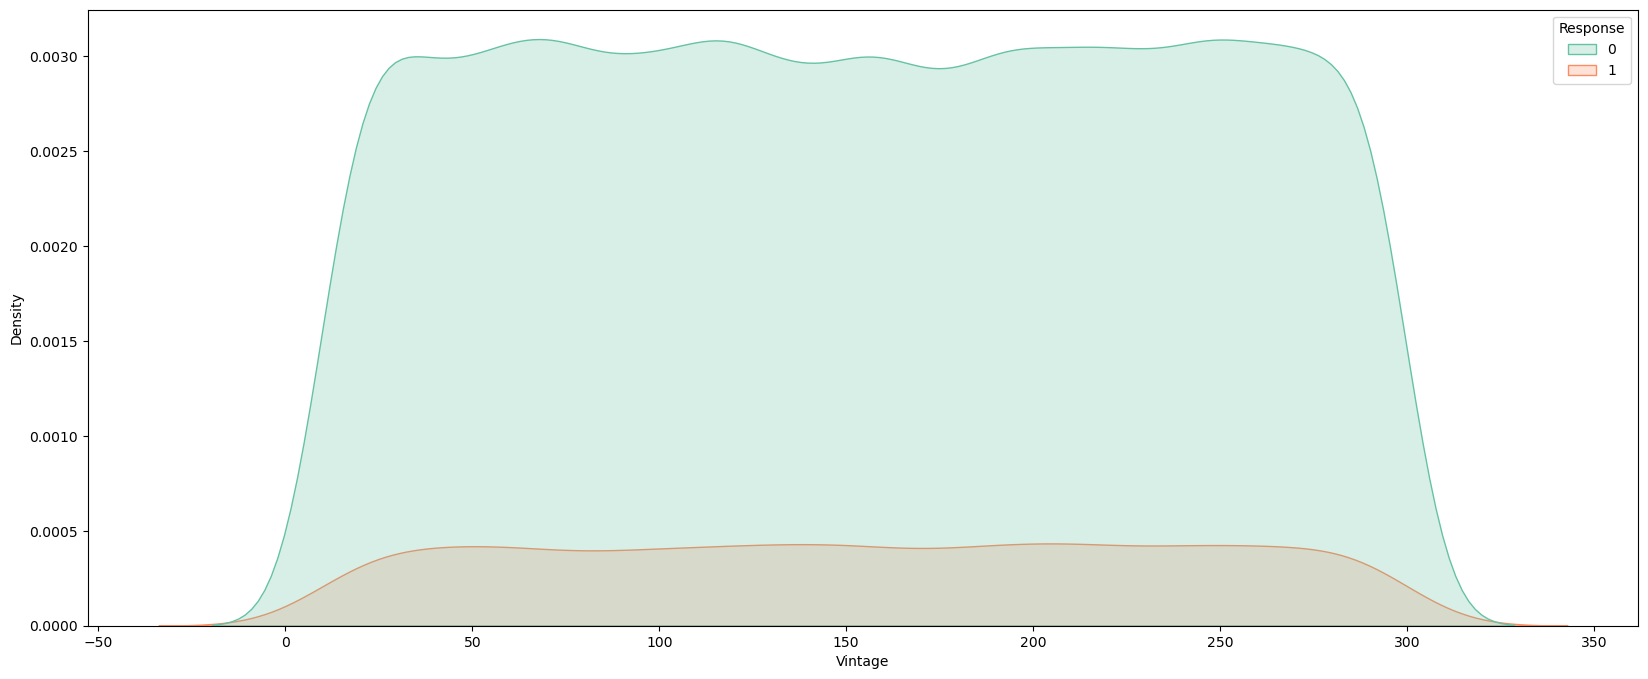

In [86]:
get_report_2(train_df, 'Vintage', 'Response')

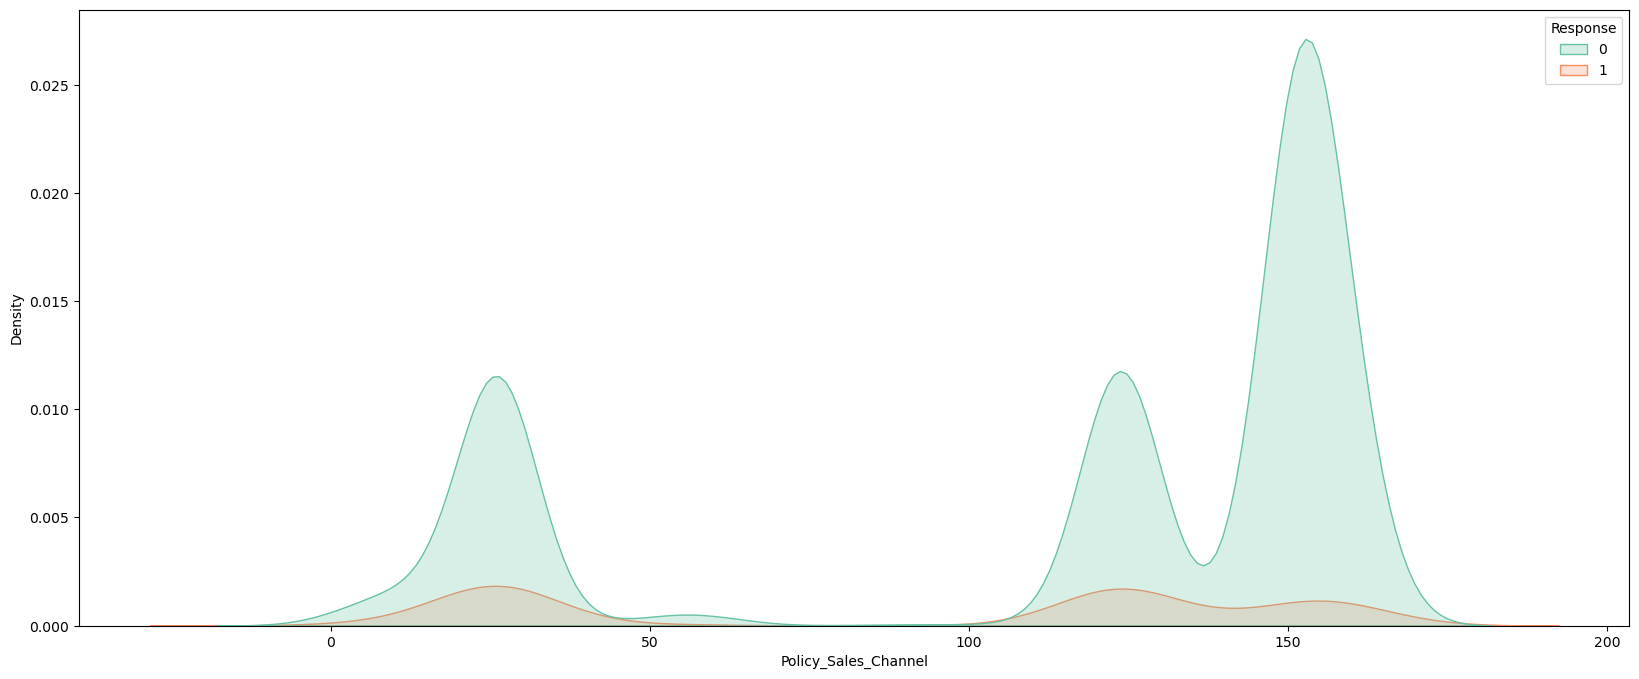

In [87]:
get_report_2(train_df, 'Policy_Sales_Channel', 'Response')

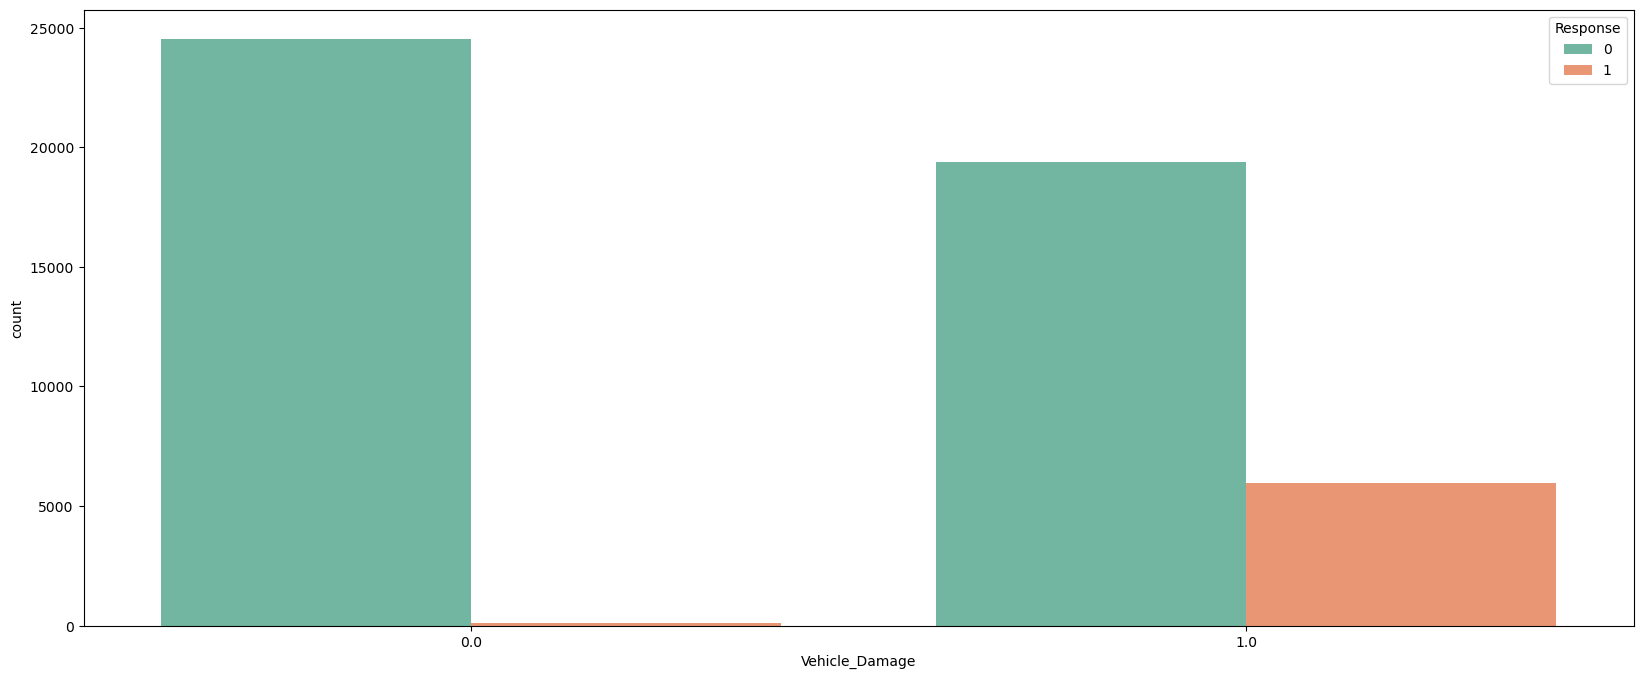

In [88]:
get_report_2(train_df, 'Vehicle_Damage', 'Response')

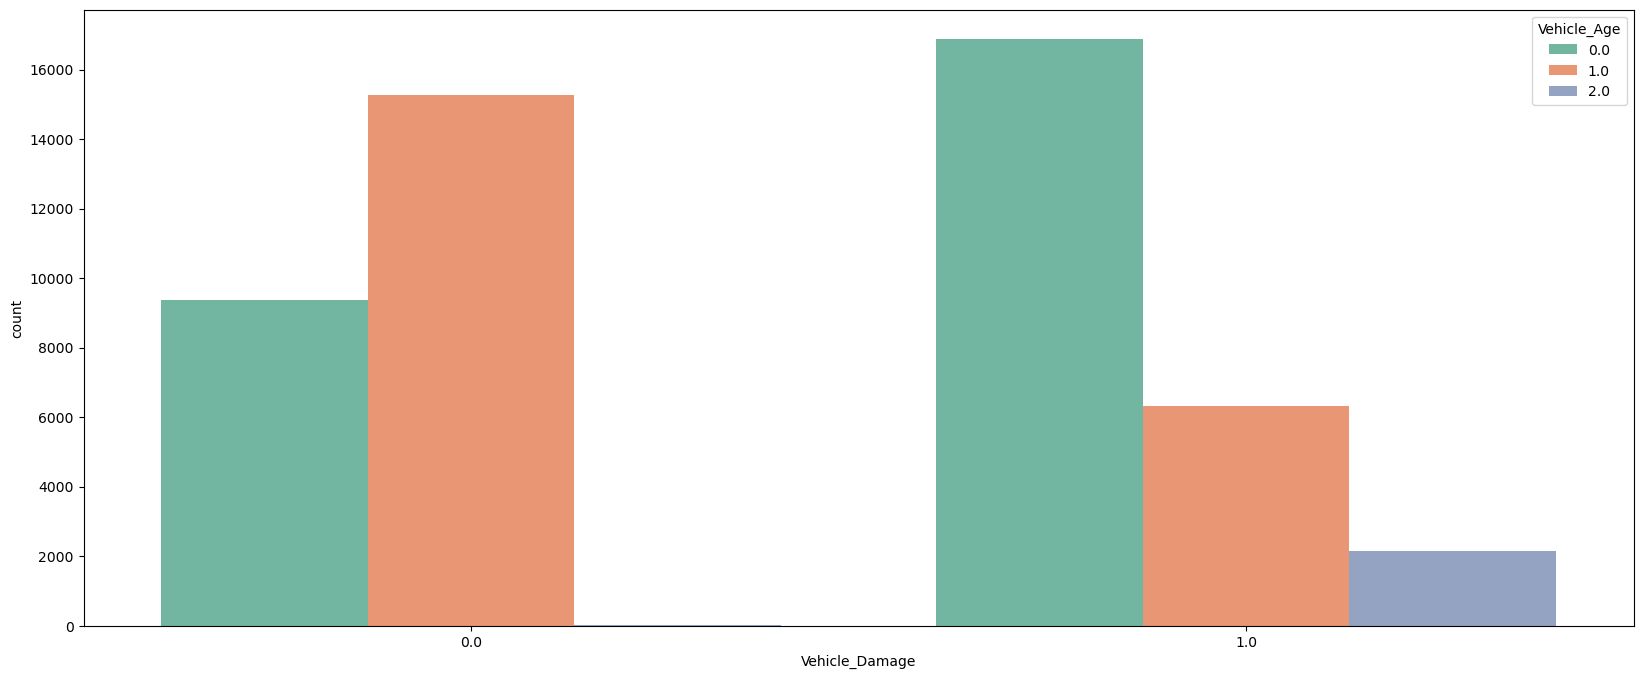

In [89]:
get_report_2(train_df, 'Vehicle_Damage', 'Vehicle_Age')

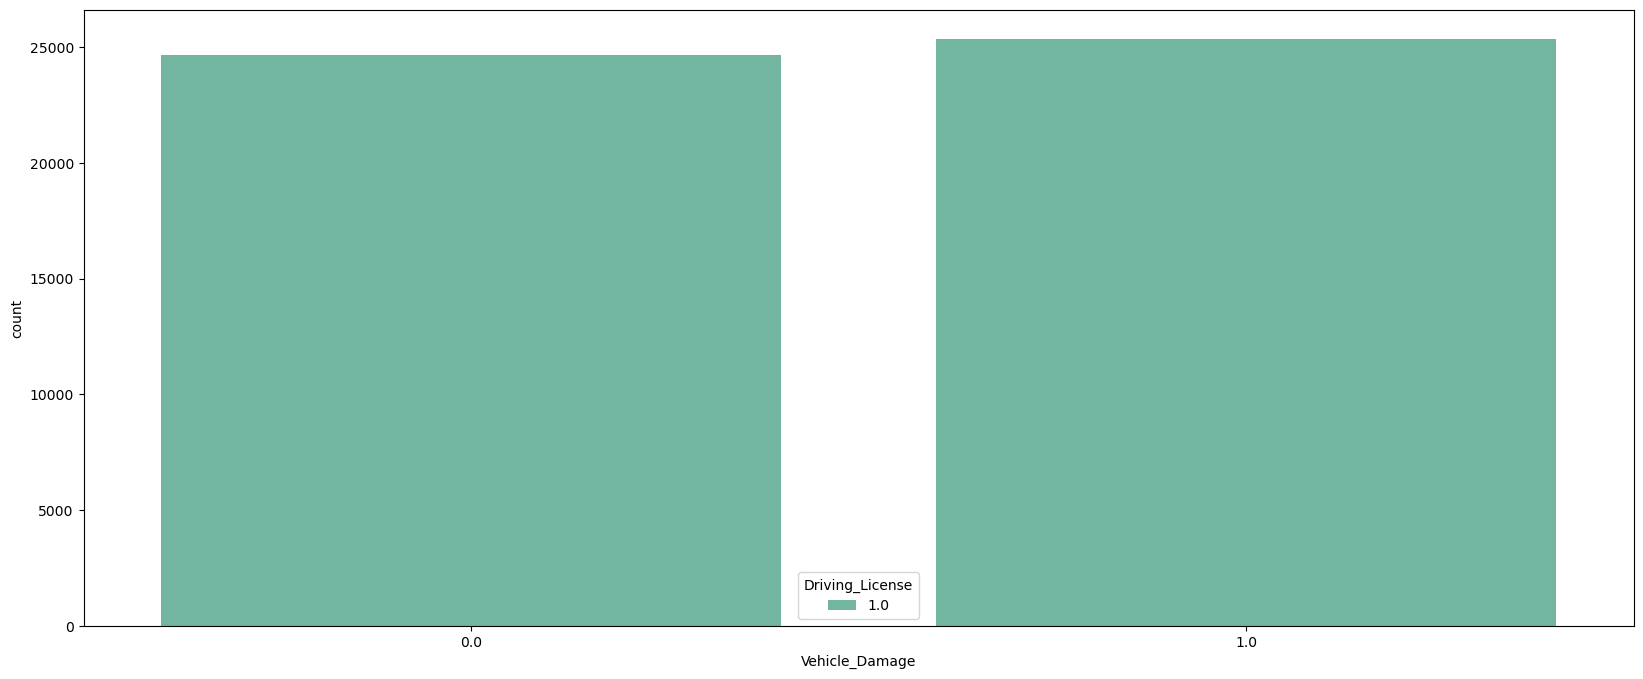

In [90]:
get_report_2(train_df, 'Vehicle_Damage', 'Driving_License')

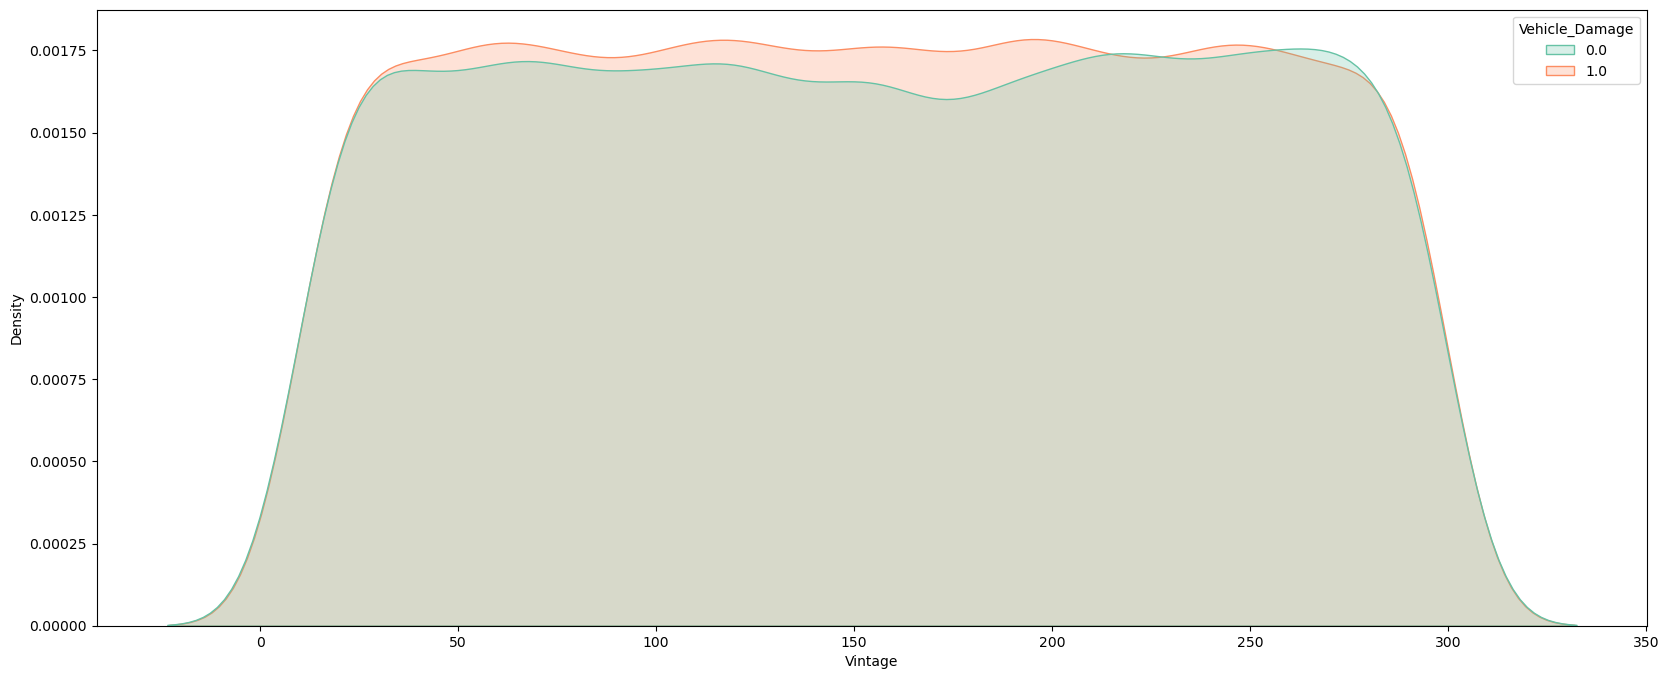

In [91]:
get_report_2(train_df, 'Vintage', 'Vehicle_Damage')

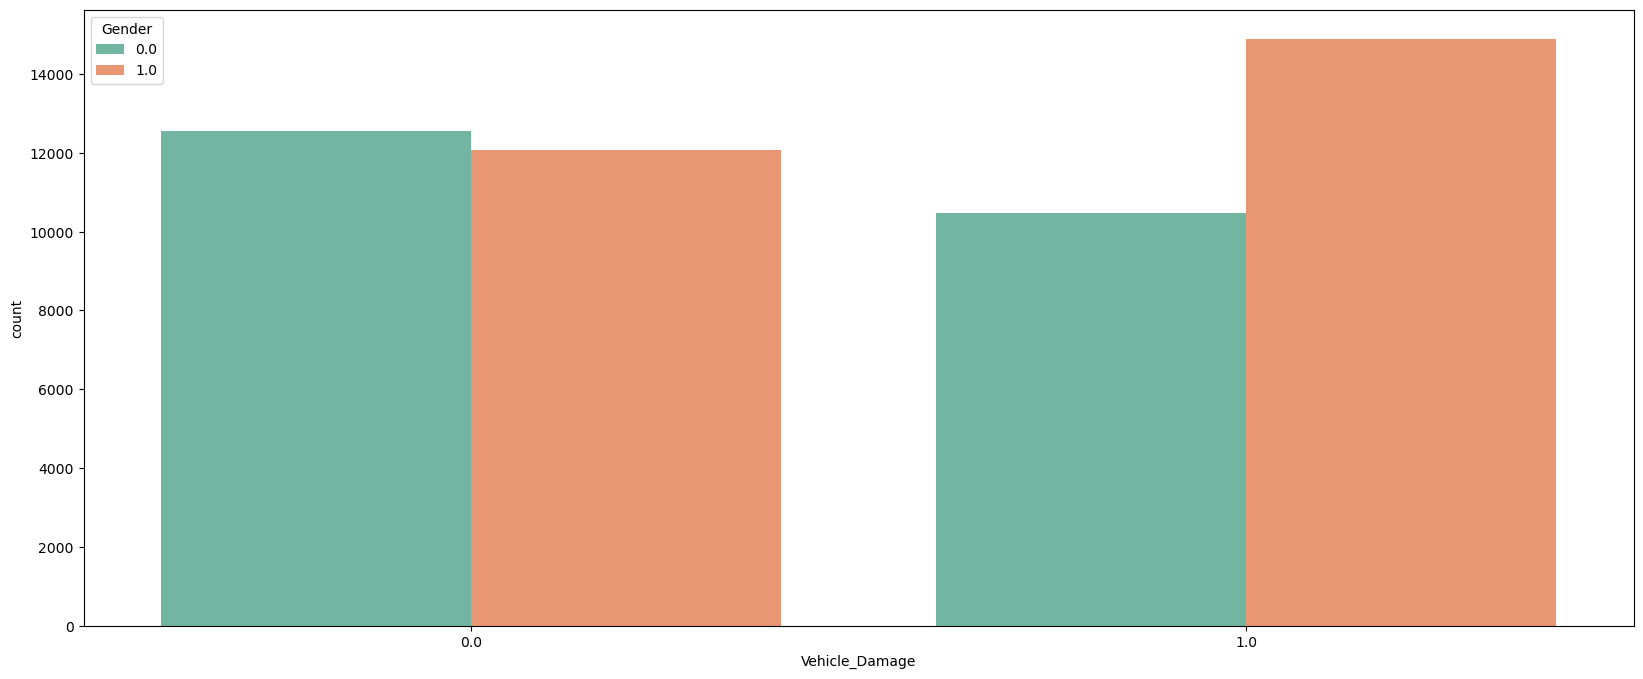

In [92]:
get_report_2(train_df, 'Vehicle_Damage', 'Gender')

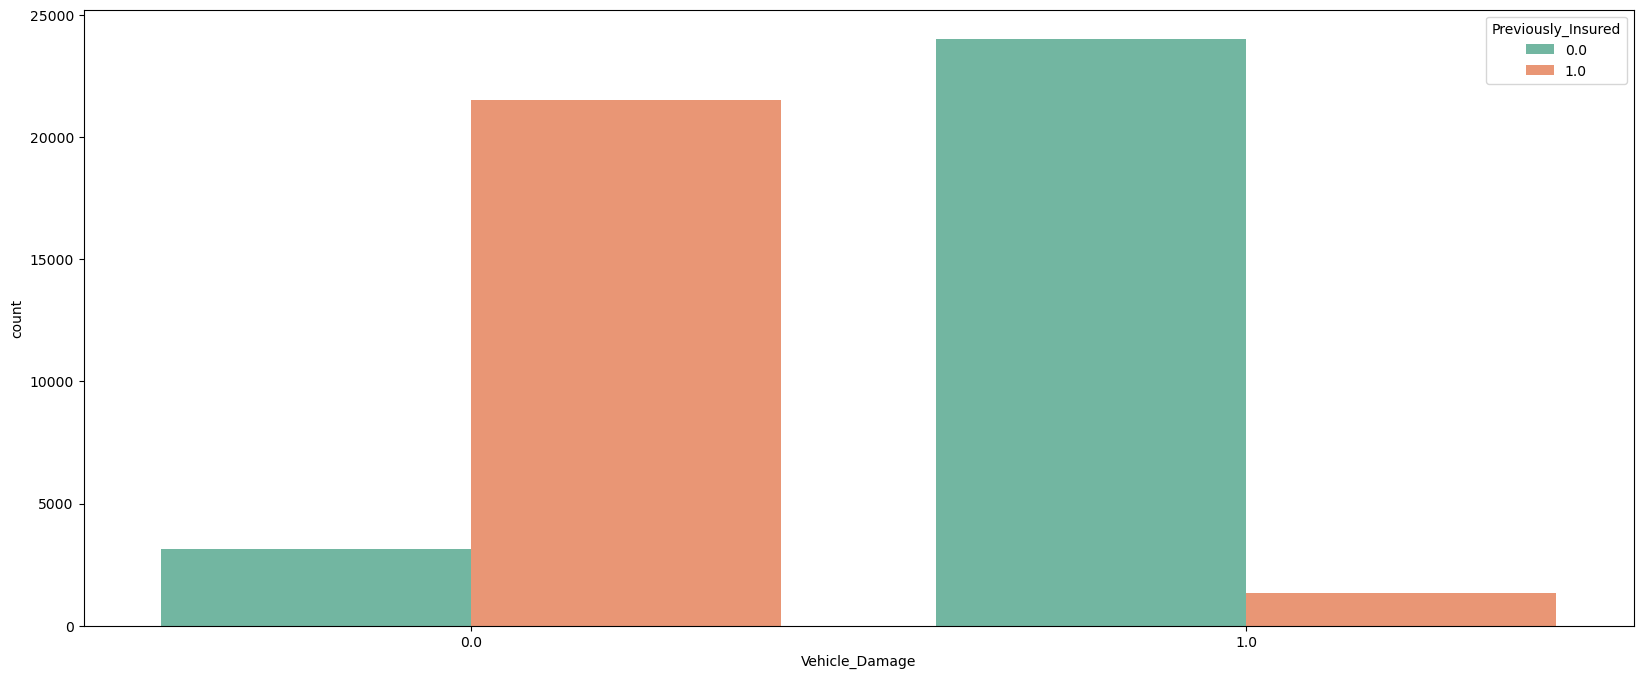

In [93]:
get_report_2(train_df, 'Vehicle_Damage', 'Previously_Insured')

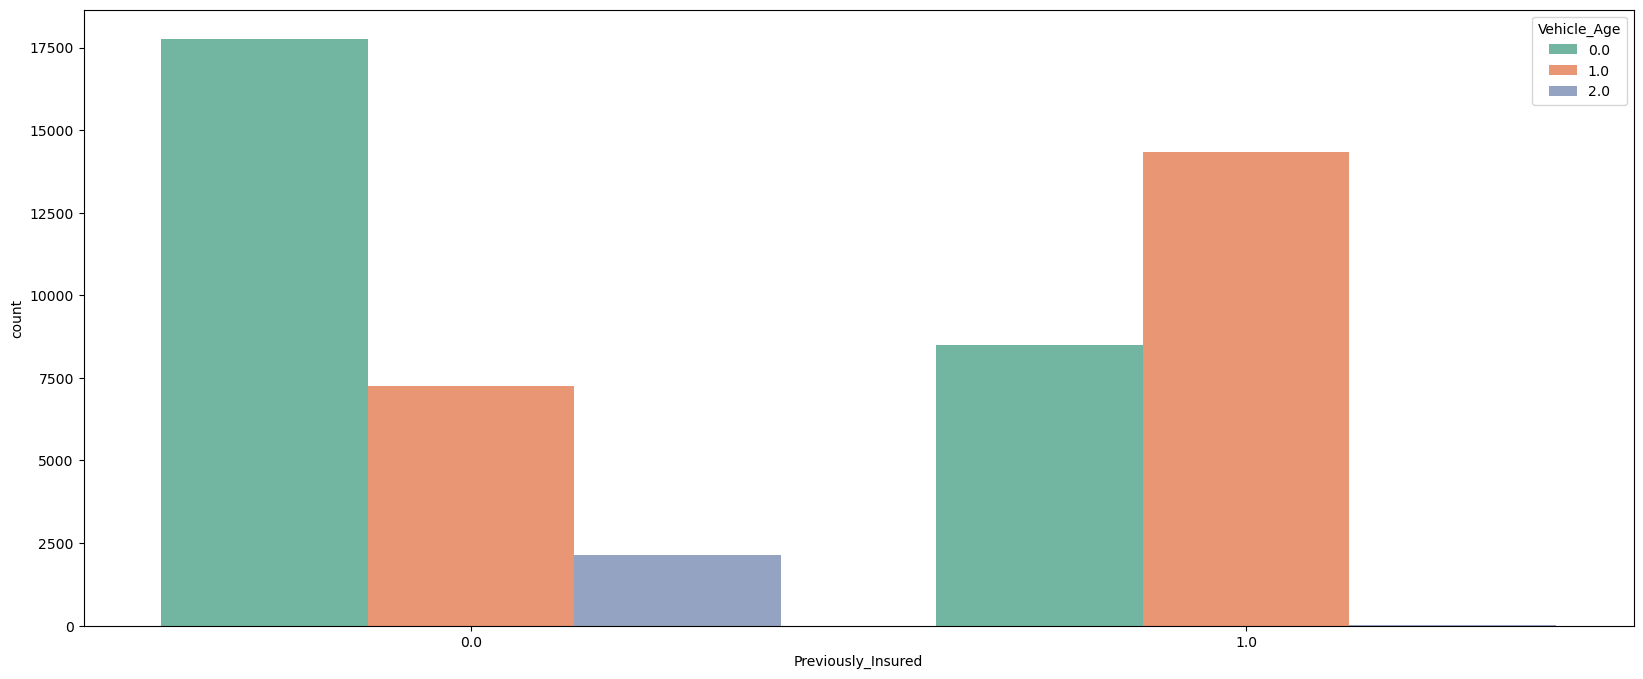

In [94]:
get_report_2(train_df, 'Previously_Insured', 'Vehicle_Age')

<AxesSubplot: >

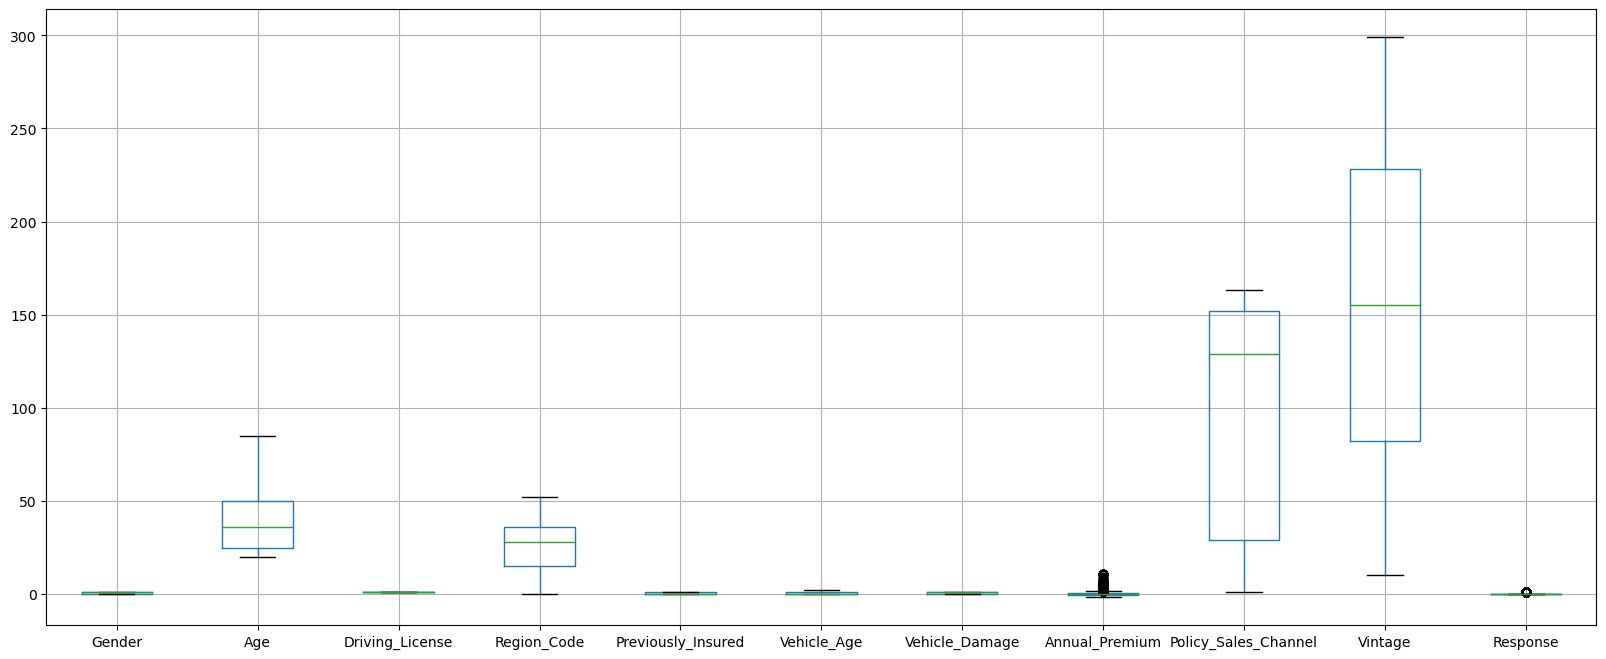

In [95]:
figure(figsize=(20, 8))
train_df.boxplot()

## `Transform Data`

In [96]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
205599,1.0,32.0,1.0,21.0,1.0,1.0,0.0,-0.107789,152.0,62.0,0
221780,1.0,26.0,1.0,28.0,0.0,1.0,1.0,0.819526,124.0,72.0,0
171331,0.0,60.0,1.0,18.0,1.0,0.0,0.0,0.266634,26.0,36.0,0
351934,0.0,25.0,1.0,19.0,1.0,1.0,0.0,0.455444,152.0,228.0,0
27493,1.0,44.0,1.0,47.0,1.0,0.0,0.0,0.340706,152.0,26.0,0


In [97]:
train_df.iloc[:, -4:-3]

,Annual_Premium
205599,-0.107789
221780,0.819526
171331,0.266634
351934,0.455444
27493,0.340706
...,...
89975,-1.622853
82558,0.657092
305717,-1.622853
294148,0.978184


In [43]:
def drop_features(df, feature):
    df = df.drop([feature], axis=1, inplace=True)
    return df

In [44]:
drop_features(train_df, 'id')

In [45]:
class encoding(BaseEstimator, TransformerMixin):
    def __init__(self, column_1=['Vehicle_Age', 'Gender',  'Vehicle_Damage']):
        self.column_1 = column_1
    def fit(self, df):
        return self
    def transform(self, df):
        oe = OrdinalEncoder()
        df[self.column_1] = oe.fit_transform(df[self.column_1])
        return df

In [46]:
class feature_scaling(BaseEstimator, TransformerMixin):
    def __init__(self, column_3=['Annual_Premium']):
        self.column_3 = column_3
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_3).issubset(df.columns)):
            stc = StandardScaler()
            df[self.column_3] = stc.fit_transform(df[self.column_3])
            return df
        else:
            print("Error")
            return df

In [47]:
class change_dtype(BaseEstimator, TransformerMixin):
    def __init__(self, column_4 = ['Age', 'Driving_License', 'Previously_Insured', 'Vintage']):
        self.column_4 = column_4
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_4).issubset(df.columns)):
            df[self.column_4] = df[self.column_4].astype('float')
            return df
        else:
            print("Error")

In [48]:
pipe = Pipeline([
    ('encoding', encoding()),
    ('scaler', feature_scaling()),
    ('dtype_conv', change_dtype()),
])

In [49]:
pipe

Pipeline(steps=[('encoding', encoding()), ('scaler', feature_scaling()),
                ('dtype_conv', change_dtype())])

In [50]:
pipe.fit_transform(train_df)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1.0,44.0,1.0,28.0,0.0,2.0,1.0,0.574539,26.0,217.0,1
1,1.0,76.0,1.0,3.0,0.0,0.0,0.0,0.172636,26.0,183.0,0
2,1.0,47.0,1.0,28.0,0.0,2.0,1.0,0.449053,26.0,27.0,1
3,1.0,21.0,1.0,11.0,1.0,1.0,0.0,-0.113018,152.0,203.0,0
4,0.0,29.0,1.0,41.0,1.0,1.0,0.0,-0.178259,152.0,39.0,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1.0,74.0,1.0,26.0,1.0,0.0,0.0,-0.022912,26.0,88.0,0
381105,1.0,30.0,1.0,37.0,1.0,1.0,0.0,0.549093,152.0,131.0,0
381106,1.0,21.0,1.0,30.0,1.0,1.0,0.0,0.264543,160.0,161.0,0
381107,0.0,68.0,1.0,14.0,0.0,2.0,1.0,0.816389,124.0,74.0,0


In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  float64
 1   Age                   381109 non-null  float64
 2   Driving_License       381109 non-null  float64
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  float64
 5   Vehicle_Age           381109 non-null  float64
 6   Vehicle_Damage        381109 non-null  float64
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 32.0 MB


In [52]:
def outlier_thresholds_iqr(df, feature, th1, th3):
    Q1 = df[feature].quantile(th1)
    Q3 = df[feature].quantile(th3)
    IQR = Q3 - Q1
    upper_limit = Q3 + 3 * IQR
    lower_limit = Q1 - 1 * IQR
    return upper_limit, lower_limit

In [53]:
for i in train_df.columns:
    if i != 'Outcome':
        print('################################')
        print(i, ":", outlier_thresholds_iqr(train_df, i, th1=0.05, th3=0.95))
    else:
        pass

################################
Gender : (4.0, -1.0)
################################
Age : (213.0, -27.0)
################################
Driving_License : (1.0, 1.0)
################################
Region_Code : (173.0, -37.0)
################################
Previously_Insured : (4.0, -1.0)
################################
Vehicle_Age : (4.0, -1.0)
################################
Vehicle_Damage : (4.0, -1.0)
################################
Annual_Premium : (10.587823610490268, -4.675522581557889)
################################
Policy_Sales_Channel : (562.0, -108.0)
################################
Vintage : (1068.0, -237.0)
################################
Response : (4.0, -1.0)


In [54]:
def check_outliers_iqr(df, feature):
    upper_limit, lower_limit = outlier_thresholds_iqr(df, feature, th1=0.05, th3=0.95)
    if df[(df[feature] > upper_limit) | (df[feature] < lower_limit)].any(axis=None):
        return True
    else:
        return False

In [55]:
from tabulate import tabulate
def replace_with_thresholds_iqr(df, features, th1=0.05, th3=0.95, replace=True):
    data = []
    for feature in features:
        if feature != 'Response':
            outliers = check_outliers_iqr(df, feature)
            count = None
            upper_limit, lower_limit = outlier_thresholds_iqr(df, feature, th1=0.05, th3=0.95)
            if outliers:
                count = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)][feature].count()
                if replace:
                    if lower_limit < 0:
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
                    else:
                        df.loc[(df[feature] < lower_limit), feature] = lower_limit
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
            outliers_status = check_outliers_iqr(df, feature)
            data.append([outliers, outliers_status, count, feature, upper_limit, lower_limit ])
    table = tabulate(data, headers=['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'], tablefmt='rst', numalign='right')
    print(table)


replace_with_thresholds_iqr(train_df, train_df.columns, th1=0.05, th3=0.95)

========  =====  =================  ====================  ====================  =============
Gender    Age      Driving_License  Region_Code             Previously_Insured    Vehicle_Age
========  =====  =================  ====================  ====================  =============
False     False                     Gender                                   4             -1
False     False                     Age                                    213            -27
True      False                812  Driving_License                          1              1
False     False                     Region_Code                            173            -37
False     False                     Previously_Insured                       4             -1
False     False                     Vehicle_Age                              4             -1
False     False                     Vehicle_Damage                           4             -1
True      False                106  Annual_Premium          

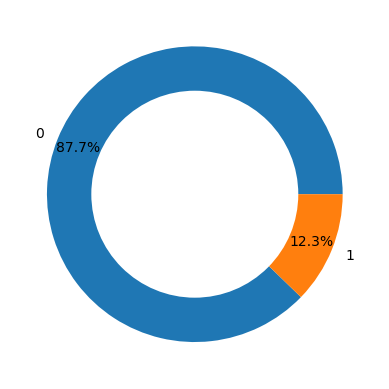

In [56]:
label = [0, 1]
plt.pie(train_df['Response'].value_counts(), labels=label,
        autopct='%1.1f%%', pctdistance=0.85)
donut_plot = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(donut_plot)

In [57]:
train_df.skew()

Gender                 -0.163590
Age                     0.672539
Driving_License         0.000000
Region_Code            -0.115266
Previously_Insured      0.167747
Vehicle_Age             0.589682
Vehicle_Damage         -0.019507
Annual_Premium          0.605944
Policy_Sales_Channel   -0.900008
Vintage                 0.003030
Response                2.301906
dtype: float64

In [58]:
def create_kde_plot(df, feature):
    sns.kdeplot(data=df, x=feature)

In [59]:
list = []
for k in train_df.columns:
    list += [k]

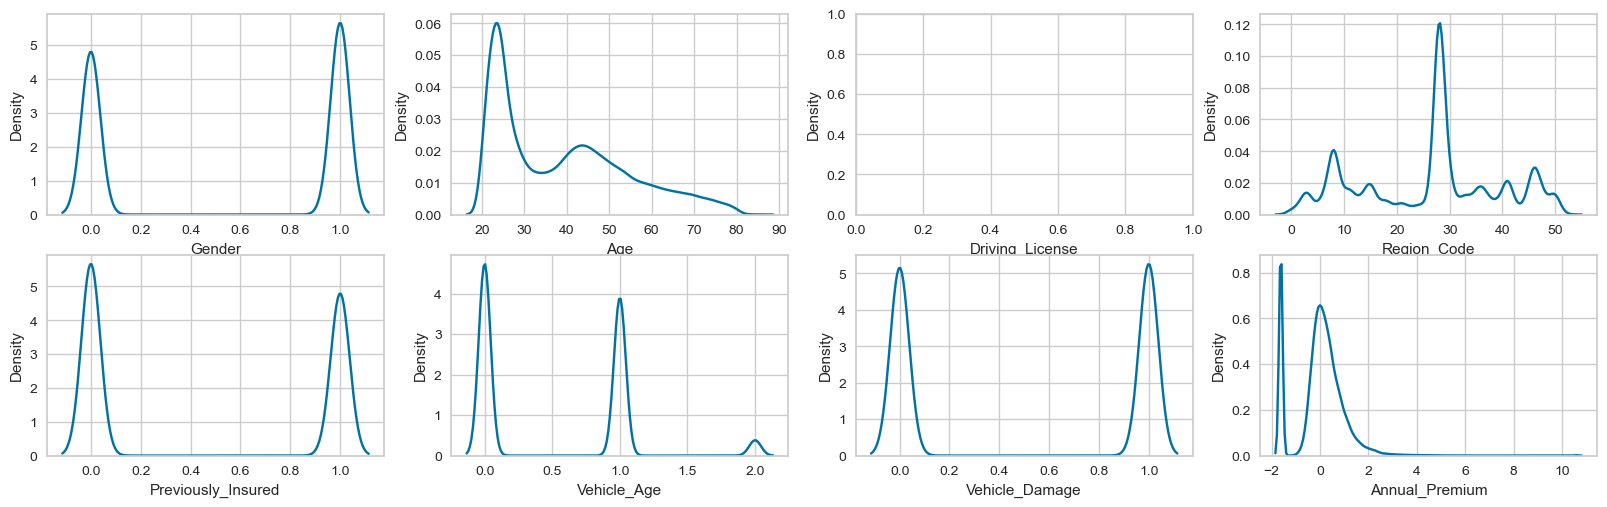

In [34]:
figure(figsize=(20, 12))
count = 8
for i in range(count):
    plt.subplot(4, 4, i+1)
    create_kde_plot(train_df, list[i])

In [60]:
train_df = train_df.sample(n=50000)

In [61]:
train_df.shape

(50000, 11)

In [62]:
x = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

In [63]:
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

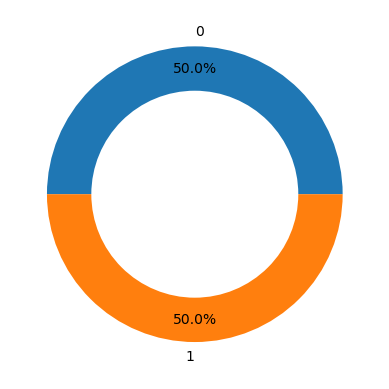

In [64]:
label = [0, 1]
plt.pie(y.value_counts(), labels=label,
        autopct='%1.1f%%', pctdistance=0.85)
donut_plot = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(donut_plot)

<AxesSubplot: >

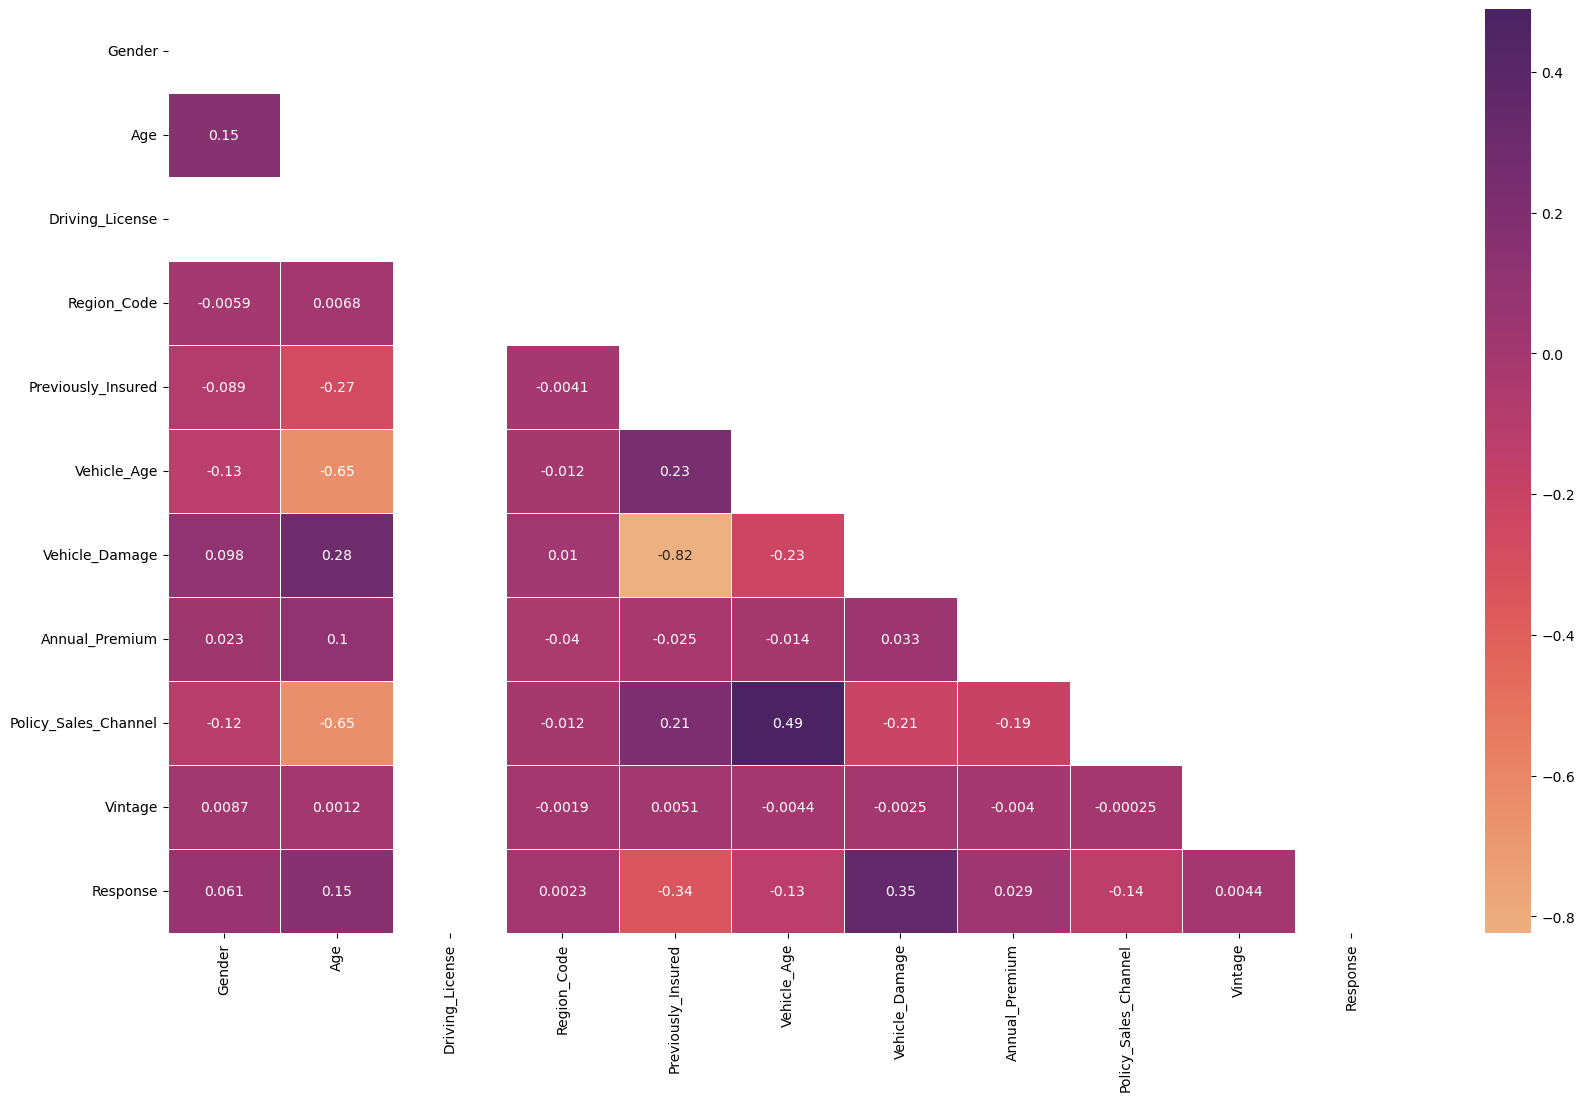

In [65]:
figure(figsize=(20, 12))
mask = np.zeros_like(train_df.corr('spearman'))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_df.corr('spearman'), annot=True, cmap='flare', linewidths=.5, mask=mask)

In [66]:
models = {
    'Logistic_Regression': LogisticRegression(C=0.04, penalty='l2', solver='liblinear', max_iter=5000, multi_class='ovr'),
    'Navie_Bayes': GaussianNB(),
    'lda': LinearDiscriminantAnalysis(),
    'Random_Forest': RandomForestClassifier(n_estimators=300, criterion='gini'),
    'Ada_boost': AdaBoostClassifier(),
    'Gradient_boost': GradientBoostingClassifier(),
    'Bagging_Classifer': BaggingClassifier(n_estimators=500, max_features=0.5, max_samples=1.0),
    'knn_classifier': KNeighborsClassifier(n_neighbors=2),
    'Decision_tree': DecisionTreeClassifier(),
    'Extr_tree': ExtraTreesClassifier(n_estimators = 100, criterion = 'gini', random_state = 0),
}

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [68]:
accuracy = []
model_name_1 = []
def train_model(model, model_name, x=x_train, y=y_train, x_test = x_test):
    print("##########################################################################")
    model = model.fit(x, y)
    y_pred = model.predict(x_test)
    acc = model.score(x_test, y_test)
    print(model_name, ":", accuracy_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    model_name_1.append(model_name)
    print("--------------------------------------------------------------------------")
    print('--------------------------------------------------------------------------')
    report = classification_report(y_test, y_pred)
    print(report)

In [69]:
for model_name, model in models.items():
    train_model(model, model_name)

##########################################################################
Logistic_Regression : 0.7832916002731618
--------------------------------------------------------------------------
--------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     13194
           1       0.71      0.97      0.82     13164

    accuracy                           0.78     26358
   macro avg       0.83      0.78      0.78     26358
weighted avg       0.83      0.78      0.78     26358

##########################################################################
Navie_Bayes : 0.7834433568556036
--------------------------------------------------------------------------
--------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     13194
           1       0.70      0.97      0

In [70]:
my_dict = dict(zip(model_name_1, accuracy))
my_dict

{'Logistic_Regression': 0.7832916002731618,
 'Navie_Bayes': 0.7834433568556036,
 'lda': 0.7858335230290614,
 'Random_Forest': 0.9158889141816526,
 'Ada_boost': 0.8511267926246301,
 'Gradient_boost': 0.8661886334319752,
 'Bagging_Classifer': 0.9331132862887928,
 'knn_classifier': 0.865923059412702,
 'Decision_tree': 0.890014416875332,
 'Extr_tree': 0.9230214735564155}

In [71]:
max_model_name = my_dict['Logistic_Regression']
best_model_name = ''
for i in my_dict.keys():
    if max_model_name < my_dict[i]:
        max_model_name = my_dict[i]
        best_model_name = i

In [72]:
model = models[best_model_name]

In [73]:
model

BaggingClassifier(max_features=0.5, n_estimators=500)

In [74]:
clf_rf =  RandomForestClassifier(n_estimators=300, criterion='gini')

In [75]:
clf_rf = clf_rf.fit(x_train, y_train)
y_pred_rf = model.predict(x_test)
print(accuracy_score(y_test, y_pred_rf))

0.9331132862887928


In [76]:
import pickle
pickle.dump(clf_rf, open('../artifacts/model.pkl', 'wb'))

In [77]:
clf_bac = BaggingClassifier(n_estimators=500, max_features=0.5, max_samples=1.0)

In [78]:
clf_bac = clf_bac.fit(x_train, y_train)
y_pred_bac = model.predict(x_test)
print(accuracy_score(y_test, y_pred_bac))

0.9331132862887928


In [79]:
x_train.shape

(61502, 10)

## `Top-3 Models`

* RandomForestClassifier : 91.3%
* BaggingClassifier      : 93%
* DecisionTreeClassifier : 89%
